<a href="https://colab.research.google.com/github/zi-onion/24-2-ESAA/blob/main/10_07_%ED%85%8D%EC%8A%A4%ED%8A%B8%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

파이썬 머신러닝 완별 가이드 개정 2판 8장 p.566-583

## 10 텍스트 분석 실습 -  캐글 Mercari Price Suggestion Challenge
일본의 대형 온라인 쇼핑몰인 Mercari사의 제품에 대해 가격 예측하는 과제

### **데이터 전처리**

In [ ]:
#구글 드라이브
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd

mercari_df= pd.read_csv('/content/drive/MyDrive/2024/ESAA/Data/mercari_train.tsv', sep='\t')
print(mercari_df.shape)
mercari_df.head(3)


(1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


In [2]:
print(mercari_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482529 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB
None


null이 너무 많음

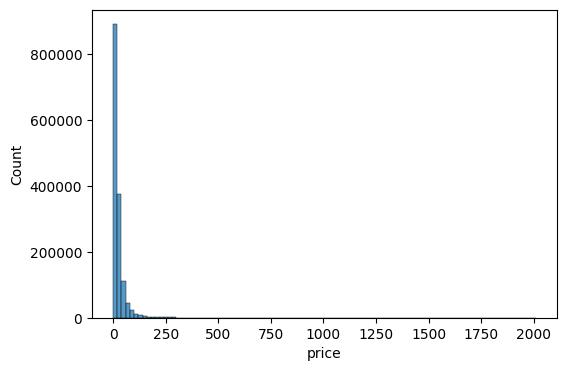

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

y_train_df = mercari_df['price']
plt.figure(figsize=(6,4))
sns.histplot(y_train_df, bins=100)
plt.show()

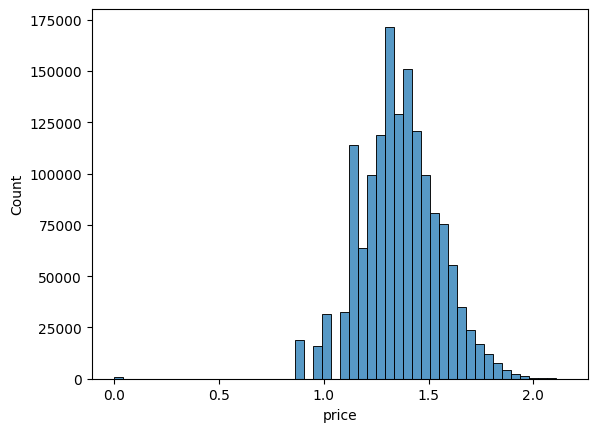

In [9]:
import numpy as np

y_train_df = np.log1p(y_train_df)
sns.histplot(y_train_df, bins=50)
plt.show()

In [10]:
mercari_df['price'] = np.log1p(mercari_df['price'])
mercari_df['price'].head(3)

,price
0,2.397895
1,3.970292
2,2.397895


In [12]:
print('Shipping 값 유형:\n', mercari_df['shipping'].value_counts())
print('item_condition_id 값 유형: \n', mercari_df['item_condition_id'].value_counts())

Shipping 값 유형:
 shipping
0    819435
1    663100
Name: count, dtype: int64
item_condition_id 값 유형: 
 item_condition_id
1    640549
3    432161
2    375479
4     31962
5      2384
Name: count, dtype: int64


- Shipping 칼럼은 배송비 유무이며, 값이 비교적 균일.
-  Item_condition_id 칼럼은 1,2,3이 주를 이룸
- item_description칼럼은 Null 값은 별로 없지만, description에 대한 별도 설명이 없는 경우 'No description yet' 값으로 되어있음.


In [16]:
boolean_cond= mercari_df['item_description']=='No description yet'
mercari_df[boolean_cond]['item_description'].count()

1482535

In [ ]:
#apply lambda에서 호출되는 대, 중, 소 분할 함수 생성, 대, 중, 소 값을 리스트로 반환
def split_cat(category_name):
    try:
        return category_name.split('/')
    except:
        return ['Other_Null', '0ther_Null', 'Other_Null']
#위의 split_cat( )을 apply lambda에서 호출해 대, 중, 소 칼럼을 mercari_df에 생성.
mercari_df ['cat_dae'], mercari_df ['cat_jung'], mercari_df ['cat_so'] = \
                        zip(*mercari_df ['category_name'].apply(lambda x : split_cat(x)))

#대분류만 값의 유형과 건수를 살펴보고, 중분류, 소분류는 값의 유형이 많으므로 분류 개수만 추출
print('대분류 유형 :\n', mercari_df['cat_dae'].value_counts())
print('중분류 개수 :',mercari_df['cat_jung'].nunique())
print('소분류 개수 :', mercari_df['cat_so'].nunique())

대분류 유형 :
 cat_dae
Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Other_Null                  6327
Name: count, dtype: int64
중분류 개수 : 114
소분류 개수 : 871


brand_name, category name, item_description 칼럼의 Null 값은 일괄적으로 ‘Other Null’로 동일하게 변경

In [ ]:
mercari_df['brand_name'] = mercari_df['brand_name'].fillna(value='Other_Null')
mercari_df['category_name'] = mercari_df['category_name'].fillna(value='Other_Null')
mercari_df['item_description'] = mercari_df['item_description'].fillna(value='Other_Null')

#각 칼럼별로 Null 값 건수 확인. 모두 0이 나와야 합니다.
mercari_df.isnull().sum()

,0
train_id,0
name,0
item_condition_id,0
category_name,0
brand_name,0
price,0
shipping,0
item_description,0
cat_dae,0
cat_jung,0


### **피처 인코딩과 피처 벡터화**
데이터 세트에 문자열 칼럼이 많음 -> 원-핫 인코딩을 수행하거나 피처 벡터화로 변환할 칼럼을 선별


- brand_name 칼럼: 인코딩 변환

In [ ]:
print('brand name 의 유형 건수 ：', mercari_df['brand_name'].nunique())
print('brand name sample 5건 : \n', mercari_df['brand_name'].value_counts()[:5])

brand name 의 유형 건수 ： 4810
brand name sample 5건 : 
 brand_name
Other_Null           632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Name: count, dtype: int64


- name 칼럼: 유형이 매우 많고, 적은 단어 위주의 텍스트 형태로 돼 있으므로 Count 기반으로 피처 벡터화 변환 진행

In [ ]:
print('name 의 종류 개수 ：', mercari_df['name'].nunique())
print('name sample 7건: \n', mercari_df['name'][:7])

name 의 종류 개수 ： 1225273
name sample 7건: 
 0    MLB Cincinnati Reds T Shirt Size XL
1       Razer BlackWidow Chroma Keyboard
2                         AVA-VIV Blouse
3                  Leather Horse Statues
4                   24K GOLD plated rose
5       Bundled items requested for Ruie
6     Acacia pacific tides santorini top
Name: name, dtype: object


- category_name 칼럼: 이전 전처리를 통해서 해당 칼럼은 대, 중, 소 분류 세 개의 칼럼인 cat_ dae, catjung, cat_so 칼럼으로 분리됨. -> cat_dae, catjung, cat_so 칼럼도 원-핫 인코딩을 적용
- shipping 칼럼: 배송비 무료 여부로서 0과 1, 두 가지 유형의 값을 가지고 있음. -> 원-핫 인코딩
- item_condition_ id: 상품 상태로서 1, 2, 3, 4, 5의 다섯 가지 유형의 값을 가지고 있음. -> 원-핫 인코딩

- item_description: 평균 문자열이 145자로 비교적 크므로 해당 칼럼은 TF-IDF로 변환

In [ ]:
pd.set_option('max_colwidth', 200)

# item_description의 평균 문자열 크기
print('item_description 평균 문자열 크기:', mercari_df['item_description'].str.len().mean())

mercari_df['item_description'][:2]

item_description 평균 문자열 크기: 18.0


,item_description
0,No description yet
1,No description yet


- 주요 칼럼 인코딩 및 피처 벡터화 변환

In [ ]:
#name 속성에 대한 피처 벡터화 변환
cnt_vec = CountVectorizer()
X_name = cnt_vec.fit_transform(mercari_df.name)

#item_description에 대한 피처 벡터화 변환
tfidf_descp = TfidfVectorizer(max_features = 50000, ngram_range= (1, 3), stop_words='english')
X_descp = tfidf_descp.fit_transform(mercari_df['item_description'])

In [ ]:
print('name vectorization shape：', X_name.shape)
print('item_description vectorization shape：', X_descp.shape)

name vectorization shape： (1482535, 105757)
item_description vectorization shape： (1482535, 1)


- CountVectorizer, TfidfVectorizer가 fit_transform()을 통해 반환하는 데이터는 희소 행렬 형태 -> X_name, X_descp와 결합돼 ML 모델을 실행하는 기반 데이터 세트로 재구성되어야 함.
  - 인코딩 대상 칼럼도 밀집 행렬 행태가 아닌 희소 행렬 형태로 인코딩을 적용한 뒤, 함께 결합
  - 사이파이 패키지 sparse 모듈의 hstack( ) 함수를 이용해 결합
- 사이킷런 원-핫 인코딩: OneHotEncoder와 LabelBinarizer
  - LabelBinarizer 클래스: 희소 행렬 형태의 원-핫 인코딩 변환을 지원
    - 생성 시 sparse_out=True로 파라미터를 설정

In [ ]:
from sklearn.preprocessing import LabelBinarizer

# brand-name, item_condition_id, shipping 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_brand_name= LabelBinarizer(sparse_output=True)
X_brand = lb_brand_name.fit_transform(mercari_df['brand_name'])
lb_item_cond_id = LabelBinarizer(sparse_output=True)
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])
lb_shipping= LabelBinarizer(sparse_output=True)
X_shipping = lb_shipping.fit_transform(mercari_df['shipping'])

# cat_dae, cat Jung, cat_so 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_cat_dae = LabelBinarizer(sparse_output=True)
X_cat_dae= lb_cat_dae.fit_transform(mercari_df['cat_dae'])
lb_cat_jung = LabelBinarizer(sparse_output=True)
X_cat_jung = lb_cat_jung.fit_transform(mercari_df ['cat_jung'])
lb_cat_so = LabelBinarizer(sparse_output=True)
X_cat_so = lb_cat_so.fit_transform(mercari_df['cat_so'])

In [ ]:
print(type(X_brand), type(X_item_cond_id), type(X_shipping))
print('X_brand shape：{0}, X_item_cond_id shape：{1}'.format(X_brand.shape, X_item_cond_id.shape))
print('X_shipping shape：{0}, X_cat_dae shape：{1}'.format(X_shipping.shape, X_cat_dae.shape))
print('X_cat_jung shape:{0}, X_cat_so shape：{1}'.format(X_cat_jung.shape, X_cat_so.shape))

<class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'>
X_brand shape：(1482535, 4810), X_item_cond_id shape：(1482535, 5)
X_shipping shape：(1482535, 1), X_cat_dae shape：(1482535, 11)
X_cat_jung shape:(1482535, 114), X_cat_so shape：(1482535, 871)


인코딩 변환된 데이터 세트: CSR 형태로 변환된 csr_matrix 타입

인코딩 칼럼이 매우 많이 생겼지만, 피처 벡터화로 텍스트 형태의 문자열이 가지는 벡터 형태의 매우 많은 칼럼과 함께 결합되므로 문제 없음.

 앞에서 피처 벡터화 변환한 데이터 세트와 희소 인코딩 변환된 데이터 세트를 hstack()을 이용해 모두 결합하기
 만들어진 결합 데이터가 비교적 많은 메모리를 잡아먹기 때문에  del '객체 변수명'과 gc.collect()로 결합 데이터를 메모리에서 삭제하기

In [ ]:
from scipy.sparse import hstack
import gc

sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

#hstack 함수를 이용해 인코딩과 벡터화를 수행한 데이터 세트를 모두 결합.
X_features_sparse= hstack(sparse_matrix_list).tocsr()
print(type(X_features_sparse), X_features_sparse.shape)

#데이터 세트가 메모리를 많이 차지하므로 사용 목적이 끝났으면 바로 메모리에서 삭제.
del X_features_sparse
gc.collect()

<class 'scipy.sparse._csr.csr_matrix'> (1482535, 111570)


53

### **릿지 회귀 모델 구축 및 평가**
- 평가 로직: RMSLE(Root Mean Square Logarithmic Error) 방식 -> rmsle(y, y_pred) 생성하기

학습 모델을 이용한 예측된 price 값은 다시 로그의 역변환인 지수(Exponential) 변환을 수행해 원복 해야함. -> evaluate_org_price(y_ test, preds) 함수 생성하기

In [ ]:
def rmsle(y, y_pred):
    #underflow, overflow를 막기 위해 log가 아닌 log1p로 rmsle 계산
    return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))

def evaluate_org_price(y_test, preds):
    #원본 데이터는 loglp로 변환되었으므로 exmpml로 원복 필요.
    preds_exmpm = np.expm1(preds)
    y_test_exmpm = np.expm1(y_test)

    #rmsle로 RMSLE 값 추출
    rmsle_result = rmsle(y_test_exmpm, preds_exmpm)
    return rmsle_result

In [ ]:
import gc
from scipy.sparse import hstack

def model_train_predict(model, matrix_list):
    #scipy.sparse 모듈의 hstack을 이용해 희소 행렬 결합
    X= hstack(matrix_list).tocsr()
    X_train, X_test, y_train, y_test=train_test_split(X, mercari_df['price'], test_size=0.2, random_state=156)

    #모델 학습 및 예측
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    del X, X_train, X_test, y_train
    gc.collect()

    return preds, y_test

In [ ]:
linear_model = Ridge(solver = "lsqr", fit_intercept=False)

sparse_matrix_list = (X_name, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds, y_test = model_train_predict(model=linear_model, matrix_list=sparse_matrix_list)
print('Item Description을 제외했을 때 rmsle 값:', evaluate_org_price(y_test, linear_preds))

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds, y_test = model_train_predict(model=linear_model, matrix_list=sparse_matrix_list)
print('Item Description을 포함한 rmsle 값:', evaluate_org_price(y_test, linear_preds))

Item Description을 제외했을 때 rmsle 값: 0.49844797831827115
Item Description을 포함한 rmsle 값: 0.4984564531681502


 Item Description을 포함했을 때 rmsle 값이 많이 감소함. -> Item description 영향이 중요함.

### **LightGBM 회귀 모델 구축과 앙상블을 이용한 최종 예측 평가**

In [ ]:
from lightgbm import LGBMRegressor

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
lgbm_model = LGBMRegressor(n_estimators=200, learning_rate=0.5, num_leaves=125, random_state=156)
lgbm_preds, y_test = model_train_predict(model = lgbm_model, matrix_list=sparse_matrix_list)
print('LightGBM rmsle 값:', evaluate_org_price(y_test, lgbm_preds))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 325.938335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31556
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 15347
[LightGBM] [Info] Start training from score 2.979514
LightGBM rmsle 값: 0.46862682526562033


In [ ]:
preds = lgbm_preds * 0.45 + linear_preds * 0.55
print('LightGBM과 Ridge를 ensemble한 최종 rmsle 값:', evaluate_org_price(y_test, preds))

LightGBM과 Ridge를 ensemble한 최종 rmsle 값: 0.47111534570318636


## 11. 정리
- 텍스트 분석 프로세스
  1.  텍스트 사전 정제 작업 등의 텍스트 정규화 작업을 수행
  2. 이들 단어들을 피처 벡터화로 변환
  3. 이렇게 생성된 피처 벡터 데이터 세트에 머신러닝 모델을 학습하고 예측 및 평가
- 텍스트 정규화 작업: 텍스트 클렌징 및 대소문자 변경, 단어 토큰화, 의미 없는 단어 필터링, 어근 추출 등 피처 벡터화를 진행하기 이전에 수행하는 다양한 사전 작업
- 피처 벡터화: BOW 의 대표 방식인 Count 기반과 TF-IDF 기반 피처 벡터화
  - 문서의 문장이 긴 경우: TF-IDF 기반의 피처 벡터가 더 정확한 결과를 도출하는 데 더 효과적
  - 피처 벡터 데이터 세트: 희소 행렬
- 텍스트 분류: 문서들을 피처 벡터화한 후 로지스틱 회귀를 적용해 문서를 지도학습 방식으로 예측 및 분류
  - 감성 분석: 지도학습 기반으로 긍정/부정 이진 분류를 적용한 방식, SentiWordNet, VADER와 같은 감성 사전 Lexicon을 이용한 방식
  - 토픽 모델링: LDA(Latent Dirichlet Allocation)를 이용
  - 텍스트 군집화:  K-평균 군집화 기법을 이용해 비슷한 문서들끼리 군집화
  - 텍스트 유사도 측정: 코사인 유사도
  - 한글로 된 영화 리뷰: KoNLPy 패키지를 이용해 긍정/부정 이진 분류를 적용
  - Mercari Price Challenge 실습: 정형 피처들과 텍스트와 같은 비정형 피처를 결합해 효과적으로 회귀 예측 모델을 구현
- 과거에는 단순히 보관용에 지나지 않았던 이들 비정형 데이터들이 머신러닝 기법의 도입으로 새로운 데이터로서의 가치를 부여받고 있음.